# ⚖️ 클래스 불균형(Class Imbalance)


---

## 1️⃣ 클래스 불균형이란?

클래스 불균형은 **데이터에서 한쪽 종류의 값이 너무 많고, 다른 쪽은 너무 적은 상태**를 말한다.  
예를 들어 “연봉이 5천만 원 이상인 사람(1)”과 “그 이하인 사람(0)”을 예측할 때  
- 0(이하) 사람이 100명  
- 1(이상) 사람이 20명  

이라면, 데이터가 **0이 훨씬 많고 1이 적은 불균형한 상태**이다.

이럴 때는 모델이 대부분 “0이라고만 예측해도” 정확도가 높아 보여서 착각하기 쉽다.  
하지만 진짜 중요한 건 “1을 얼마나 잘 맞추느냐”이다.

---

## 2️⃣ 왜 문제가 될까?

모델은 보통 많은 데이터를 더 믿는다.  
그래서 다수(예: 0) 쪽을 너무 잘 배우고, 소수(예: 1) 쪽을 무시하게 된다.  

결국 **희귀하지만 중요한 데이터**(예: 사기 거래, 암 진단 등)를 못 알아보는 일이 생긴다.  
이건 “시험문제 대부분은 쉬운 문제인데, 어려운 문제를 다 틀리는 학생”과 비슷하다.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
import koreanize_matplotlib
from utils import ohe_transform

In [2]:
data = pd.read_csv("./data/salary2.csv")
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
data = data.drop_duplicates()
data = data.dropna()
data = data.reset_index(drop=True)
data['class'] = data['class'].apply(lambda x: 1 if x == ' >50K' else 0)
data['class'].value_counts()
X = data.drop('class', axis=1)
y = data['class']

## 3️⃣ 해결 방법 1: 데이터 나눌 때 주의하기

데이터를 **훈련(train)** 과 **시험(test)** 으로 나눌 때,  
각 부분에도 **클래스 비율이 비슷하게** 들어가야 한다.

이럴 때 `stratify` 옵션을 사용한다.  
이건 “비율 맞춰 나누기”라고 생각하면 된다.

---

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=10)

In [6]:
X_train, X_test = ohe_transform(X_train, X_test)

In [7]:
X_test

,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,...,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,education-num,capital-gain,capital-loss,hours-per-week
22149,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,26,9,0,0,40
21899,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,33,16,0,0,40
12634,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,41,10,0,0,50
1171,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,42,10,0,0,70
4839,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,24,5,0,0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25349,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,50,15,0,0,40
34503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,64,16,0,0,80
15058,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,35,9,0,0,50
28083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,27,6,0,0,60


## 4️⃣ 해결 방법 2: 모델에게 ‘가중치’를 주기

소수 클래스(적은 데이터 쪽)에 **더 중요한 점수(weight)** 를 주면 된다.  
이건 “시험에서 어려운 문제를 맞추면 점수를 더 주는 것”과 비슷하다.

- 예: `class_weight='balanced'`  
  이렇게 하면 모델이 자동으로 “적은 데이터 쪽에 점수”를 더 준다.

이 방법은 **데이터를 새로 만들지 않고**, 모델만 살짝 조정하는 방법이다.

---

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# decisionTree 모델의 경우 class_weight="balanced"

In [9]:
dtc = DecisionTreeClassifier(max_depth=4, class_weight="balanced", random_state=10)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82     11706
           1       0.52      0.86      0.65      3990

    accuracy                           0.76     15696
   macro avg       0.73      0.80      0.74     15696
weighted avg       0.83      0.76      0.78     15696



In [10]:
# class_weight="balanced" 유무 비교
dtc = DecisionTreeClassifier(max_depth=4, random_state=10)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     11706
           1       0.75      0.51      0.61      3990

    accuracy                           0.83     15696
   macro avg       0.80      0.73      0.75     15696
weighted avg       0.83      0.83      0.82     15696



# random_forest의 경우 class_weight="balanced"

In [11]:
rfc = RandomForestClassifier(max_depth=4, n_estimators=300, class_weight="balanced", n_jobs=-1, random_state=10)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     11706
           1       0.51      0.87      0.64      3990

    accuracy                           0.75     15696
   macro avg       0.72      0.79      0.73     15696
weighted avg       0.83      0.75      0.77     15696



In [12]:
# class_weight="balanced" 유무 비교
rfc = RandomForestClassifier(max_depth=4, n_estimators=300, n_jobs=-1, random_state=10)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89     11706
           1       0.91      0.27      0.42      3990

    accuracy                           0.81     15696
   macro avg       0.85      0.63      0.65     15696
weighted avg       0.83      0.81      0.77     15696



# xgboost 의 경우 scale_pos_weight= 0 / 1 비율
ratio = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

In [13]:
from xgboost import XGBClassifier

In [14]:
ratio = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
ratio

np.float64(2.9338345864661655)

In [15]:
xgb = XGBClassifier(max_depth=3, n_estimators=500, n_jobs=-1, random_state=10)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11706
           1       0.77      0.67      0.72      3990

    accuracy                           0.87     15696
   macro avg       0.83      0.80      0.81     15696
weighted avg       0.86      0.87      0.86     15696



In [16]:
xgb = XGBClassifier(max_depth=3, n_estimators=500, scale_pos_weight=ratio, n_jobs=-1, random_state=10)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     11706
           1       0.63      0.85      0.72      3990

    accuracy                           0.83     15696
   macro avg       0.79      0.84      0.80     15696
weighted avg       0.86      0.83      0.84     15696



# lightgbm 의 경우 is_unbalance=True

In [17]:
from lightgbm import LGBMClassifier

In [18]:
lgbm = LGBMClassifier(max_depth=3, n_estimators=500, n_jobs=-1, random_state=10, verbose=-1)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     11706
           1       0.78      0.66      0.72      3990

    accuracy                           0.87     15696
   macro avg       0.83      0.80      0.81     15696
weighted avg       0.86      0.87      0.86     15696



In [19]:
lgbm = LGBMClassifier(max_depth=3, n_estimators=500, is_unbalance=True, n_jobs=-1, random_state=10, verbose=-1)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     11706
           1       0.63      0.86      0.73      3990

    accuracy                           0.83     15696
   macro avg       0.79      0.84      0.80     15696
weighted avg       0.86      0.83      0.84     15696



## 5️⃣ 해결 방법 3: 데이터 양을 맞춰주기(데이터 증폭/축소)

* imbalanced-learn, smote/cluster-centroids
* https://imbalanced-learn.org/stable/
* 머신러닝 알고리즘을 통해 비슷한 데이터를 생성/축소
* **반드시 train 데이터에만 적용**

In [20]:
#!pip install imbalanced-learn

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [22]:
result_base = []
for i in range(1,11):
    lgbm = LGBMClassifier(max_depth=i, n_estimators=500, n_jobs=-1, random_state=10, verbose=-1)
    lgbm.fit(X_train, y_train)
    pred = lgbm.predict(X_test)
    result_base.append(dict(
        strategy='None',
        max_depth=i,
        accuracy=accuracy_score(y_test, pred),
        precision=precision_score(y_test, pred),
        recall=recall_score(y_test, pred), 
        f1=f1_score(y_test, pred)
    ))
result_base_df = pd.DataFrame(result_base)
result_base_df

,strategy,max_depth,accuracy,precision,recall,f1
0,None,1,0.851809,0.774587,0.588221,0.668661
1,None,2,0.863723,0.782251,0.642857,0.705737
2,None,3,0.866017,0.777255,0.662907,0.715542
3,None,4,0.865698,0.773070,0.667669,0.716514
4,None,5,0.863214,0.765180,0.666416,0.712391
5,None,6,0.859964,0.755271,0.664411,0.706933
6,None,7,0.859136,0.754070,0.661654,0.704846
7,None,8,0.858372,0.752068,0.660652,0.703402
8,None,9,0.858818,0.752851,0.661905,0.704455
9,None,10,0.857607,0.748936,0.661654,0.702595


### (1) 소수 데이터를 늘리기 (Over-sampling)
오버샘플링(SMOTE): 소수 클래스를 “비슷한 점들 사이”에서 보간해 새 데이터를 생성한다.<br> 경계에서 과적합이 생기지 않도록 k_neighbors를 3~10에서 조정해본다.<br>

소수 데이터를 **복사하거나 새로 만들어서** 비율을 맞춘다.<br>

- 단순 복사: 같은 데이터를 여러 번 사용한다.  
- **SMOTE** 방법: 비슷한 데이터를 살짝 바꿔서 새로운 데이터를 만든다.  
  → 예를 들어, 친구 A와 B의 키가 160cm, 165cm라면  
  → 그 중간값 162cm 근처의 새 데이터를 만드는 느낌이다.

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
smt = SMOTE(random_state=10, k_neighbors=5, n_jobs=-1)
smt_X, smt_y = smt.fit_resample(X_train, y_train)
print(y_train.value_counts(), smt_y.value_counts())

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


class
0    17559
1     5985
Name: count, dtype: int64 class
0    17559
1    17559
Name: count, dtype: int64


In [25]:
result_smote = []
for i in range(1,11):
    lgbm = LGBMClassifier(max_depth=i, n_estimators=500, n_jobs=-1, random_state=10, verbose=-1)
    lgbm.fit(smt_X, smt_y)
    pred = lgbm.predict(X_test)
    result_smote.append(dict(
        strategy='smote',
        max_depth=i,
        accuracy=accuracy_score(y_test, pred),
        precision=precision_score(y_test, pred),
        recall=recall_score(y_test, pred), 
        f1=f1_score(y_test, pred)
    ))
result_smote_df = pd.DataFrame(result_smote)
result_smote_df

,strategy,max_depth,accuracy,precision,recall,f1
0,smote,1,0.833970,0.647611,0.760902,0.699700
1,smote,2,0.857480,0.720948,0.716792,0.718864
2,smote,3,0.863277,0.741361,0.709774,0.725224
3,smote,4,0.863596,0.742587,0.709273,0.725548
4,smote,5,0.861493,0.740594,0.700501,0.719990
5,smote,6,0.860920,0.740741,0.696742,0.718068
6,smote,7,0.860092,0.737427,0.698246,0.717302
7,smote,8,0.860856,0.740032,0.697744,0.718266
8,smote,9,0.858945,0.736296,0.693484,0.714249
9,smote,10,0.858626,0.735318,0.693484,0.713788


### (2) 다수 데이터를 줄이기 (Under-sampling)
언더샘플링: 다수 클래스를 일부만 사용한다. 학습은 빨라지지만 정보 손실이 생길 수 있다.<br>
데이터가 너무 많은 쪽(예: 0)을 **일부만 사용**해서 비율을 맞춘다. <br>
하지만 정보가 줄어들 수 있다는 단점이 있다.

In [26]:
from imblearn.under_sampling import RandomUnderSampler

In [27]:
rus = RandomUnderSampler(random_state=10)
rus_X, rus_y = rus.fit_resample(X_train, y_train)
print(y_train.value_counts(), rus_y.value_counts())

class
0    17559
1     5985
Name: count, dtype: int64 class
0    5985
1    5985
Name: count, dtype: int64


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [28]:
result_under = []
for i in range(1,11):
    lgbm = LGBMClassifier(max_depth=i, n_estimators=500, n_jobs=-1, random_state=10, verbose=-1)
    lgbm.fit(rus_X, rus_y)
    pred = lgbm.predict(X_test)
    result_under.append(dict(
        strategy='under',
        max_depth=i,
        accuracy=accuracy_score(y_test, pred),
        precision=precision_score(y_test, pred),
        recall=recall_score(y_test, pred), 
        f1=f1_score(y_test, pred)
    ))
result_under_df = pd.DataFrame(result_under)
result_under_df

,strategy,max_depth,accuracy,precision,recall,f1
0,under,1,0.814348,0.595424,0.841353,0.697341
1,under,2,0.830721,0.620242,0.861654,0.721284
2,under,3,0.829065,0.617262,0.862155,0.719440
3,under,4,0.825242,0.610648,0.862406,0.715013
4,under,5,0.823904,0.608842,0.859398,0.712742
5,under,6,0.820400,0.603135,0.858145,0.708389
6,under,7,0.821674,0.605045,0.859649,0.710218
7,under,8,0.819317,0.601549,0.856642,0.706782
8,under,9,0.819636,0.602187,0.855890,0.706966
9,under,10,0.819126,0.601338,0.855890,0.706381


### (3) 둘 다 섞기
많은 쪽은 조금 줄이고, 적은 쪽은 조금 늘리는 방법도 있다.<br>  
이건 “균형 맞추기” 느낌이다.<br>
혼합(SMOTEENN): 오버+언더를 함께 써서 노이즈를 줄이고 균형을 잡는다.<br>

비교 지표는 불균형 문제에서는 보통 F1/Recall 위주로 보는 것이 좋다.

---

In [29]:
from imblearn.combine import SMOTEENN

In [30]:
smtenn = SMOTEENN(random_state=10, n_jobs=-1)
sen_X, sen_y = smtenn.fit_resample(X_train, y_train)
print(y_train.value_counts(), sen_y.value_counts())

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\

class
0    17559
1     5985
Name: count, dtype: int64 class
1    14750
0    11255
Name: count, dtype: int64


In [31]:
result_smtenn = []
for i in range(1,11):
    lgbm = LGBMClassifier(max_depth=i, n_estimators=500, n_jobs=-1, random_state=10, verbose=-1)
    lgbm.fit(sen_X, sen_y)
    pred = lgbm.predict(X_test)
    result_smtenn.append(dict(
        strategy='smtenn',
        max_depth=i,
        accuracy=accuracy_score(y_test, pred),
        precision=precision_score(y_test, pred),
        recall=recall_score(y_test, pred), 
        f1=f1_score(y_test, pred)
    ))
result_smtenn_df = pd.DataFrame(result_smtenn)
result_smtenn_df

,strategy,max_depth,accuracy,precision,recall,f1
0,smtenn,1,0.794725,0.562036,0.871930,0.683497
1,smtenn,2,0.818361,0.598376,0.868170,0.708457
2,smtenn,3,0.820973,0.601900,0.873434,0.712679
3,smtenn,4,0.823522,0.606050,0.873684,0.715664
4,smtenn,5,0.820209,0.600898,0.871679,0.711393
5,smtenn,6,0.820273,0.601564,0.867669,0.710518
6,smtenn,7,0.818107,0.598439,0.864662,0.707330
7,smtenn,8,0.817023,0.596914,0.862907,0.705677
8,smtenn,9,0.816960,0.596777,0.863158,0.705665
9,smtenn,10,0.816068,0.595531,0.861654,0.704292


## 6️⃣ 해결 방법 4: 모델 평가 방법 바꾸기

불균형 데이터에서는 **정확도(accuracy)** 하나만 보면 안 된다.  
다른 지표를 함께 봐야 한다.

| 지표 이름 | 뜻 | 설명 |
|------------|------|------|
| **정밀도(Precision)** | “맞다고 한 것 중 진짜 맞은 비율” | 예측이 얼마나 신중한가 |
| **재현율(Recall)** | “진짜 맞는 것 중 맞춘 비율” | 놓친 게 적은가 |
| **F1 점수** | 정밀도와 재현율의 평균 | 균형 잡힌 평가 |
| **ROC-AUC / PR-AUC** | 여러 임계값 기준으로 본 전체 성능 | 전반적인 판단력 |

> 💡 **중요한 문제를 놓치면 안 될 때(예: 암 진단)**  
> → **Recall(재현율)** 이 더 중요하다.  
> **정확히 맞히는 게 중요할 때(예: 스팸 필터)**  
> → **Precision(정밀도)** 가 더 중요하다.

---

# base, over, under, over+under 결과 비교

In [32]:
import pandas as pd

# 1) 실험 결과 데이터프레임 모으기 (존재하는 것만 자동 수집)
frames = []
for name in ["result_base_df", "result_smote_df", "result_under_df", "result_smtenn_df"]:
    if name in globals():
        frames.append(globals()[name])

if not frames:
    raise ValueError("결합할 결과 데이터프레임이 없습니다. (result_*_df 변수를 생성했는지 확인)")

# 2) 하나로 결합
result_all_df = pd.concat(frames, ignore_index=True)

# 3) 점수 컬럼을 숫자형 보장 (혹시 모를 타입 이슈 방지)
for col in ["accuracy", "precision", "recall", "f1"]:
    result_all_df[col] = pd.to_numeric(result_all_df[col], errors="coerce")

# 4) 확인 (원하면 주석 해제)
# display(result_all_df.head())

# -------------------------------
# 방법 A) 단순 Top-3 (동점 무시, 상위 3개만)
# -------------------------------
metrics = ["f1", "recall", "precision", "accuracy"]

print("==== [방법 A] 각 지표별 단순 Top-3 ====\n")
for m in metrics:
    top3 = (
        result_all_df
        .sort_values(m, ascending=False)
        .head(3)[["strategy", "max_depth", m]]
        .reset_index(drop=True)
    )
    print(f"[{m.upper()}] Top-3")
    display(top3)
    print()

# -------------------------------
# 방법 B) 동점 포함 Top-3 (dense rank<=3 전부)
# -------------------------------
print("==== [방법 B] 각 지표별 동점 포함 Top-3 ====\n")
for m in metrics:
    # rank: 1,2,3 까지 모두 포함 (동점 처리)
    result_all_df[f"rank_{m}"] = result_all_df[m].rank(method="dense", ascending=False)
    top_uniq = (
        result_all_df[result_all_df[f"rank_{m}"] <= 3]
        .sort_values([m, "strategy", "max_depth"], ascending=[False, True, True])
        [["strategy", "max_depth", m, f"rank_{m}"]]
        .reset_index(drop=True)
    )
    print(f"[{m.upper()}] 동점 포함 Top-3 (rank ≤ 3)")
    display(top_uniq)
    print()


==== [방법 A] 각 지표별 단순 Top-3 ====

[F1] Top-3


,strategy,max_depth,f1
0,smote,4,0.725548
1,smote,3,0.725224
2,under,2,0.721284



[RECALL] Top-3


,strategy,max_depth,recall
0,smtenn,4,0.873684
1,smtenn,3,0.873434
2,smtenn,1,0.871930



[PRECISION] Top-3


,strategy,max_depth,precision
0,None,2,0.782251
1,None,3,0.777255
2,None,1,0.774587



[ACCURACY] Top-3


,strategy,max_depth,accuracy
0,None,3,0.866017
1,None,4,0.865698
2,None,2,0.863723



==== [방법 B] 각 지표별 동점 포함 Top-3 ====

[F1] 동점 포함 Top-3 (rank ≤ 3)


,strategy,max_depth,f1,rank_f1
0,smote,4,0.725548,1.0
1,smote,3,0.725224,2.0
2,under,2,0.721284,3.0



[RECALL] 동점 포함 Top-3 (rank ≤ 3)


,strategy,max_depth,recall,rank_recall
0,smtenn,4,0.873684,1.0
1,smtenn,3,0.873434,2.0
2,smtenn,1,0.871930,3.0



[PRECISION] 동점 포함 Top-3 (rank ≤ 3)


,strategy,max_depth,precision,rank_precision
0,None,2,0.782251,1.0
1,None,3,0.777255,2.0
2,None,1,0.774587,3.0



[ACCURACY] 동점 포함 Top-3 (rank ≤ 3)


,strategy,max_depth,accuracy,rank_accuracy
0,None,3,0.866017,1.0
1,None,4,0.865698,2.0
2,None,2,0.863723,3.0



## 7️⃣ 교차검증(k-fold cross validation)

데이터를 여러 번 나누어서 훈련과 테스트를 반복하는 방법이다.  
이건 “시험을 5번 보고 평균 점수를 내는 것”과 같다.  
이렇게 하면 “우연히 점수가 잘 나온 것”을 막을 수 있다.

---



## 1) K-Fold 개념도

데이터를 `K`개로 나누고, 매번 한 조각을 **검증(val)** 으로, 나머지를 **학습(train)** 으로 사용한다.  
아래 코드는 **해치(///)** 를 이용해 검증 조각을 표시한다.


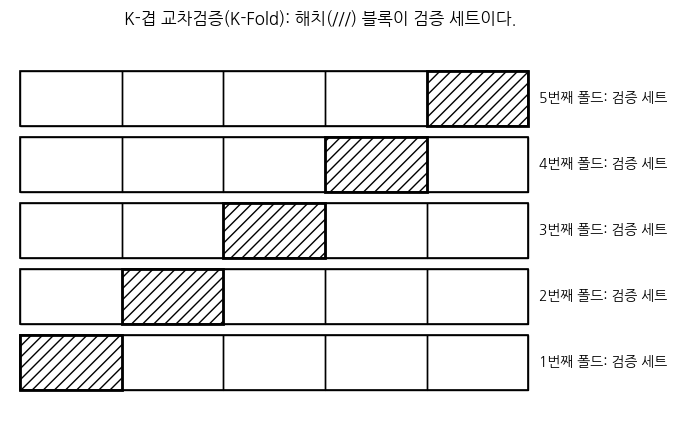

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import koreanize_matplotlib  # 한글 폰트 자동 적용

def plot_kfold(n_splits=5):
    width = 10.0
    height = 1.0
    fig, ax = plt.subplots(figsize=(8, 2 + n_splits*0.6))

    for i in range(n_splits):
        y = i * 1.2
        # 전체 데이터 구간 그리기
        ax.add_patch(Rectangle((0, y), width, height, fill=False, linewidth=1.2))
        
        # 각 폴드(조각)를 반복하며, 검증 폴드만 해치(///)로 표시
        for j in range(n_splits):
            x0 = j * width / n_splits
            w = width / n_splits
            hatch = '///' if j == i else None
            lw = 2 if j == i else 1
            rect = Rectangle((x0, y), w, height, fill=False, linewidth=lw, hatch=hatch)
            ax.add_patch(rect)
        
        # 오른쪽에 폴드 번호와 검증 폴드 표시
        ax.text(width + 0.2, y + height / 2, f"{i+1}번째 폴드: 검증 세트", va="center")

    ax.set_xlim(-0.2, width + 2)
    ax.set_ylim(-0.5, n_splits * 1.2 + 0.5)
    ax.axis("off")
    ax.set_title("K-겹 교차검증(K-Fold): 해치(///) 블록이 검증 세트이다.")
    plt.show()

plot_kfold(5)



## 2) Stratified K-Fold: 비율을 지키는 분할

불균형 데이터에서는 각 폴드의 **클래스 비율**이 원본과 비슷해야 한다.  
아래 그래프는 비층화(랜덤)와 층화(비율 유지)의 **양성 비율**을 비교한 막대그래프이다.


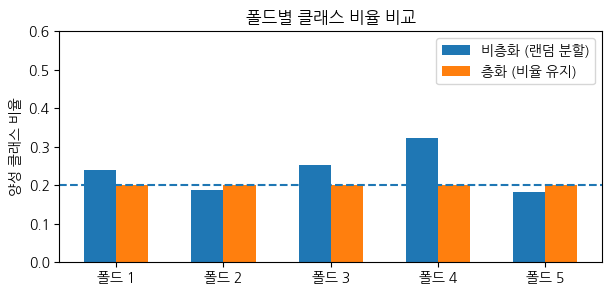

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stratified_bar(folds=5, pos_ratio=0.2, seed=42):
    rng = np.random.RandomState(seed)
    non_stratified = np.clip(rng.normal(pos_ratio, 0.08, size=folds), 0.01, 0.49)
    stratified = np.full(folds, pos_ratio)
    idx = np.arange(folds)

    fig, ax = plt.subplots(figsize=(7,3))
    # 층화되지 않은 분할과 층화된 분할 비교
    ax.bar(idx - 0.15, non_stratified, width=0.3, label="비층화 (랜덤 분할)")
    ax.bar(idx + 0.15, stratified, width=0.3, label="층화 (비율 유지)")
    
    # 전체 평균 비율 기준선
    ax.axhline(pos_ratio, linestyle="--")

    # x축 라벨과 눈금
    ax.set_xticks(idx)
    ax.set_xticklabels([f"폴드 {i+1}" for i in range(folds)])

    # y축 범위와 제목 설정
    ax.set_ylim(0, 0.6)
    ax.set_ylabel("양성 클래스 비율")
    ax.set_title("폴드별 클래스 비율 비교")
    ax.legend()
    plt.show()

plot_stratified_bar()



## 3) TimeSeriesSplit: 시간 순서를 지키는 분할

시간이 있는 데이터는 **과거로 학습하고 미래를 검증**해야 한다.  
아래 그림은 학습 구간이 점점 커지고, 바로 다음 구간을 검증으로 쓰는 모습을 그린다.


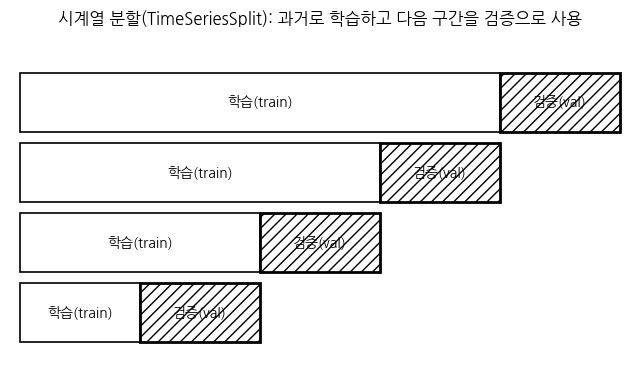

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_timeseries_splits(splits=4):
    fig, ax = plt.subplots(figsize=(8, 2 + splits*0.6))
    width = 12.0

    # 각 분할(fold)에 대해 반복
    for i in range(splits):
        y = i * 1.2
        train_w = (i + 1) * width / (splits + 1)
        val_w = width / (splits + 1)

        # 학습(train) 구간
        ax.add_patch(Rectangle((0, y), train_w, 1.0, fill=False, linewidth=1.2))
        # 검증(val) 구간
        ax.add_patch(Rectangle((train_w, y), val_w, 1.0, fill=False, linewidth=2, hatch='///'))

        # 텍스트 표시 (가운데 정렬)
        ax.text(train_w / 2, y + 0.5, "학습(train)", ha="center", va="center")
        ax.text(train_w + val_w / 2, y + 0.5, "검증(val)", ha="center", va="center")

    ax.set_xlim(-0.2, width + 0.2)
    ax.set_ylim(-0.5, splits * 1.2 + 0.5)
    ax.axis("off")
    ax.set_title("시계열 분할(TimeSeriesSplit): 과거로 학습하고 다음 구간을 검증으로 사용")
    plt.show()

plot_timeseries_splits()



## 4) 데이터 누수(Leakage) 그림

검증에서 알면 안 되는 정보를 미리 사용하는 실수를 **누수**라고 한다.  
아래 코드는 **나쁜 예**와 **좋은 예**를 한 그림에 간단히 정리한다.


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


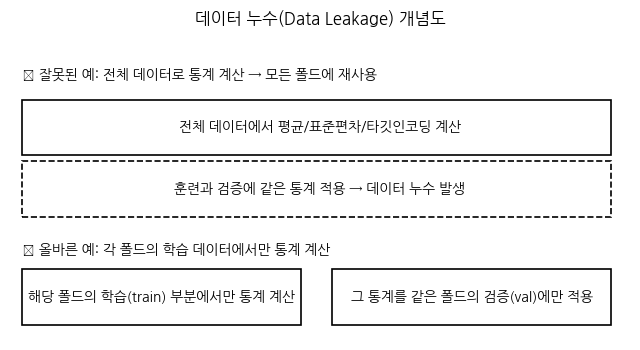

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_leakage():
    fig, ax = plt.subplots(figsize=(8,4))
    ax.axis("off")

    # ❌ 나쁜 예시
    ax.text(0.02, 0.85, "❌ 잘못된 예: 전체 데이터로 통계 계산 → 모든 폴드에 재사용", fontsize=10)
    ax.add_patch(Rectangle((0.02, 0.6), 0.95, 0.18, fill=False, linewidth=1.2))
    ax.text(0.5, 0.69, "전체 데이터에서 평균/표준편차/타깃인코딩 계산", ha="center", va="center")

    ax.add_patch(Rectangle((0.02, 0.4), 0.95, 0.18, fill=False, linewidth=1.2, linestyle='--'))
    ax.text(0.5, 0.49, "훈련과 검증에 같은 통계 적용 → 데이터 누수 발생", ha="center", va="center")

    # ✅ 올바른 예시
    ax.text(0.02, 0.28, "✅ 올바른 예: 각 폴드의 학습 데이터에서만 통계 계산", fontsize=10)
    ax.add_patch(Rectangle((0.02, 0.05), 0.45, 0.18, fill=False, linewidth=1.2))
    ax.text(0.245, 0.14, "해당 폴드의 학습(train) 부분에서만 통계 계산", ha="center", va="center")

    ax.add_patch(Rectangle((0.52, 0.05), 0.45, 0.18, fill=False, linewidth=1.2))
    ax.text(0.745, 0.14, "그 통계를 같은 폴드의 검증(val)에만 적용", ha="center", va="center")

    ax.set_title("데이터 누수(Data Leakage) 개념도")
    plt.show()

plot_leakage()


In [37]:
# 비교 목표:
# - (A) K-Fold 교차검증 평균 성능 (train 내부 fold로 검증)
# - (B) Hold-out(교차검증 없이) 성능 (전체 X_train으로 학습 → X_test로 평가)
# 동일한 max_depth(1~10)에 대해 두 결과를 나란히 비교한다.

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# ----------------------------------
# (A) Stratified K-Fold 설정 및 실행
# ----------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

kfold_rows = []
for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    print(f"===== Fold {i} 시작 =====")
    for depth in range(1, 11):
        lgbm = LGBMClassifier(
            max_depth=depth,
            n_estimators=500,
            n_jobs=-1,
            random_state=42,
            verbose=-1
        )
        lgbm.fit(X_tr, y_tr)
        pred = lgbm.predict(X_val)

        kfold_rows.append({
            "max_depth": depth,
            "fold": i,
            "cv_accuracy": accuracy_score(y_val, pred),
            "cv_precision": precision_score(y_val, pred, zero_division=0),
            "cv_recall": recall_score(y_val, pred, zero_division=0),
            "cv_f1": f1_score(y_val, pred, zero_division=0)
        })

kfold_df = pd.DataFrame(kfold_rows)

# max_depth별 교차검증 평균(+표준편차) 집계
cv_mean = (
    kfold_df
    .groupby("max_depth")[["cv_accuracy", "cv_precision", "cv_recall", "cv_f1"]]
    .agg(["mean", "std"])
)
# 컬럼 평탄화
cv_mean.columns = [f"{m}_{sfx}" for m, sfx in cv_mean.columns]
cv_mean = cv_mean.reset_index()

print("===== (A) 교차검증 결과 요약 (각 max_depth별 평균±표준편차) =====")
display(cv_mean.sort_values("cv_f1_mean", ascending=False))

# ----------------------------------
# (B) Hold-out(교차검증 없이) 성능: 전체 X_train으로 학습 → X_test로 평가
# ----------------------------------
holdout_rows = []
for depth in range(1, 11):
    lgbm = LGBMClassifier(
        max_depth=depth,
        n_estimators=500,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    lgbm.fit(X_train, y_train)
    pred = lgbm.predict(X_test)

    holdout_rows.append({
        "max_depth": depth,
        "ho_accuracy": accuracy_score(y_test, pred),
        "ho_precision": precision_score(y_test, pred, zero_division=0),
        "ho_recall": recall_score(y_test, pred, zero_division=0),
        "ho_f1": f1_score(y_test, pred, zero_division=0)
    })

holdout_df = pd.DataFrame(holdout_rows)

print("===== (B) Hold-out 결과 (각 max_depth별 X_test 평가) =====")
display(holdout_df.sort_values("ho_f1", ascending=False))

# ----------------------------------
# (A) vs (B) 비교 테이블 만들기
# ----------------------------------
compare_df = pd.merge(cv_mean, holdout_df, on="max_depth", how="inner")

# 지표별로 차이(holdout - cv_mean) 계산
for m in ["accuracy", "precision", "recall", "f1"]:
    compare_df[f"delta_{m}"] = compare_df[f"ho_{m}"] - compare_df[f"cv_{m}_mean"]

# 정렬: holdout F1 기준 상위
print("===== K-Fold 평균 vs Hold-out 비교 (max_depth별) =====")
display(
    compare_df
    .sort_values("ho_f1", ascending=False)
    .reset_index(drop=True)
    [[
        "max_depth",
        "cv_accuracy_mean", "cv_precision_mean", "cv_recall_mean", "cv_f1_mean",
        "ho_accuracy", "ho_precision", "ho_recall", "ho_f1",
        "delta_accuracy", "delta_precision", "delta_recall", "delta_f1"
    ]]
)

# 요약 코멘트 예시 출력 (선택)
best_row = compare_df.loc[compare_df["ho_f1"].idxmax()]
print(
    f"\n[요약] Hold-out F1 최고 max_depth={int(best_row['max_depth'])} | "
    f"CV F1(mean)={best_row['cv_f1_mean']:.4f} vs Hold-out F1={best_row['ho_f1']:.4f} "
    f"(Δ={best_row['delta_f1']:.4f})"
)


===== Fold 1 시작 =====
===== Fold 2 시작 =====
===== Fold 3 시작 =====
===== Fold 4 시작 =====
===== Fold 5 시작 =====
===== (A) 교차검증 결과 요약 (각 max_depth별 평균±표준편차) =====


,max_depth,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std
2,3,0.867185,0.003011,0.781396,0.009596,0.663158,0.007868,0.717395,0.006114
3,4,0.864084,0.002370,0.768711,0.009284,0.665831,0.010163,0.713501,0.005194
4,5,0.863192,0.002792,0.763833,0.011621,0.668839,0.005336,0.713120,0.003606
5,6,0.861536,0.003040,0.759443,0.010843,0.666667,0.009507,0.709959,0.005793
1,2,0.865274,0.002964,0.786042,0.009562,0.645948,0.010153,0.709079,0.006835
6,7,0.859964,0.002882,0.753569,0.008257,0.667502,0.009725,0.707879,0.006314
7,8,0.858605,0.002850,0.749735,0.009282,0.666332,0.007738,0.705528,0.005318
9,10,0.857968,0.003842,0.747619,0.010598,0.666332,0.009481,0.704591,0.007664
8,9,0.858393,0.003429,0.750235,0.009840,0.664160,0.007881,0.704540,0.006579
0,1,0.854146,0.004306,0.782591,0.015604,0.590476,0.006975,0.673038,0.008135


===== (B) Hold-out 결과 (각 max_depth별 X_test 평가) =====


,max_depth,ho_accuracy,ho_precision,ho_recall,ho_f1
3,4,0.865698,0.773070,0.667669,0.716514
2,3,0.866017,0.777255,0.662907,0.715542
4,5,0.863214,0.765180,0.666416,0.712391
5,6,0.859964,0.755271,0.664411,0.706933
1,2,0.863723,0.782251,0.642857,0.705737
6,7,0.859136,0.754070,0.661654,0.704846
8,9,0.858818,0.752851,0.661905,0.704455
7,8,0.858372,0.752068,0.660652,0.703402
9,10,0.857607,0.748936,0.661654,0.702595
0,1,0.851809,0.774587,0.588221,0.668661


===== K-Fold 평균 vs Hold-out 비교 (max_depth별) =====


,max_depth,cv_accuracy_mean,cv_precision_mean,cv_recall_mean,cv_f1_mean,ho_accuracy,ho_precision,ho_recall,ho_f1,delta_accuracy,delta_precision,delta_recall,delta_f1
0,4,0.864084,0.768711,0.665831,0.713501,0.865698,0.773070,0.667669,0.716514,0.001614,0.004359,0.001838,0.003013
1,3,0.867185,0.781396,0.663158,0.717395,0.866017,0.777255,0.662907,0.715542,-0.001168,-0.004140,-0.000251,-0.001854
2,5,0.863192,0.763833,0.668839,0.713120,0.863214,0.765180,0.666416,0.712391,0.000021,0.001347,-0.002423,-0.000729
3,6,0.861536,0.759443,0.666667,0.709959,0.859964,0.755271,0.664411,0.706933,-0.001571,-0.004172,-0.002256,-0.003026
4,2,0.865274,0.786042,0.645948,0.709079,0.863723,0.782251,0.642857,0.705737,-0.001550,-0.003791,-0.003091,-0.003343
5,7,0.859964,0.753569,0.667502,0.707879,0.859136,0.754070,0.661654,0.704846,-0.000828,0.000501,-0.005848,-0.003033
6,9,0.858393,0.750235,0.664160,0.704540,0.858818,0.752851,0.661905,0.704455,0.000425,0.002615,-0.002256,-0.000085
7,8,0.858605,0.749735,0.666332,0.705528,0.858372,0.752068,0.660652,0.703402,-0.000233,0.002333,-0.005681,-0.002126
8,10,0.857968,0.747619,0.666332,0.704591,0.857607,0.748936,0.661654,0.702595,-0.000361,0.001318,-0.004678,-0.001996
9,1,0.854146,0.782591,0.590476,0.673038,0.851809,0.774587,0.588221,0.668661,-0.002336,-0.008004,-0.002256,-0.004377



[요약] Hold-out F1 최고 max_depth=4 | CV F1(mean)=0.7135 vs Hold-out F1=0.7165 (Δ=0.0030)



## 5) 핵심 요약

- 교차검증은 **여러 번 시험 보고 평균 내기**이다.  
- **Stratified**는 클래스 비율을 지켜 공정하게 나누는 방법이다.  
- **TimeSeriesSplit**은 시간 순서를 지켜 과거로 학습하고 미래를 검증한다.  
- **GroupKFold**는 같은 사람/회사/기기처럼 연결된 데이터를 함께 묶는다.  
- **누수 방지**를 위해 폴드의 **학습 안에서만** 통계를 계산하고 검증에 적용한다.


# 실제로 중요한 것은 무엇일까?

모델이 정답을 많이 맞히는 것(Accuracy)도 중요하지만,  
**불균형한 데이터에서는 ‘무엇을 놓치지 않아야 하는가’, ‘무엇을 틀리면 안 되는가’가 더 중요하다.**  
핀테크 회사에서 고객의 연봉을 예측하는 경우도 마찬가지이다.

---

### 🎯 불균형 데이터의 현실

대부분의 고객은 `연봉 <= 50K`인 반면,  
`연봉 > 50K`인 **고소득 고객은 소수**이다.  
즉, 데이터 자체가 **클래스 불균형(Class Imbalance)** 상태인 것이다.

이런 상황에서 단순히 "정확도(Accuracy)"로만 모델을 평가하면,  
모델이 소수 클래스를 거의 맞히지 않아도 높은 점수가 나올 수 있다.

> 예: 90%가 저소득자라면  
> 모델이 전부 “저소득”이라고만 예측해도 정확도 90%가 나온다.  
> 하지만 “고소득 고객을 전혀 못 잡는” 엉터리 모델이 된다.

---

### 💡 그래서 지표를 다르게 봐야 한다

예를 들어 👇

- **고소득 고객(>50K)을 놓치면?**  
  → VIP 금융상품, 프리미엄 카드, 투자 서비스의 주요 대상 고객을 잃는다.  
  → 즉, **놓치지 않는 것(Recall)** 이 더 중요하다.  
  실제로 연봉이 높지만 모델이 “낮다”고 판단하면,  
  중요한 고객을 일반 고객으로 분류해 **수익 기회를 잃게 된다.**

- **저소득 고객을 잘못 고소득으로 예측하면?**  
  → 한도 초과 대출, 리스크 높은 신용 평가, 부적절한 상품 추천이 발생한다.  
  → 즉, **틀리지 않는 것(Precision)** 이 더 중요하다.  
  실제로 연봉이 낮은데 “높다”고 예측하면,  
  **채무 불이행이나 신용 리스크 증가**로 이어질 수 있다.

---

### 📊 관점별로 중요한 지표가 다르다

| 관점 | 핵심 지표 | 이유 |
|------|------------|------|
| 마케팅 / 고객 확보 | **Recall (재현율)** | 고소득자를 놓치면 기회 손실 |
| 대출 / 리스크 관리 | **Precision (정밀도)** | 저소득자를 잘못 분류하면 손실 위험 |
| 전체 모델 평가 | **F1-score** | Precision과 Recall의 균형 |

---

### ⚙️ 불균형 데이터를 다루는 방법

이처럼 한쪽 클래스(고소득)가 적을 때는 **모델이 균형 있게 학습하도록** 도와야 한다.

| 단계 | 해야 할 일 | 이유 |
|------|-------------|------|
| 1 | 데이터 분포 확인 | 불균형 비율 확인 |
| 2 | `stratify` 옵션으로 데이터 나누기 | 훈련/테스트의 비율 유지 |
| 3 | `class_weight='balanced'` | 소수 클래스의 영향력 보정 |
| 4 | SMOTE 등 오버샘플링 적용 | 소수 클래스 데이터 늘리기 |
| 5 | Precision / Recall / F1-score 확인 | 단순 정확도보다 실질적 성능 평가 |
| 6 | StratifiedKFold로 교차검증 | 편향되지 않은 안정적 성능 확보 |

---

## 💡 마무리

클래스 불균형 문제는 단순히 “데이터 개수 차이”가 아니라,  
**비즈니스에서 무엇을 더 중요하게 볼 것인가의 문제**이다.  

핀테크 회사가 연봉을 예측할 때도  
> “고객을 놓치지 않는 게 더 중요한가?”  
> “틀리지 않는 게 더 중요한가?”  

이 질문에 따라 **지표의 선택**과 **데이터 처리 방식(SMOTE, class_weight 등)** 이 달라진다.  

결국 **좋은 모델이란, 데이터의 불균형을 이해하고  
업무의 목적에 맞게 지표를 선택하는 모델**이다.
